In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite") 

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
first_row=session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11b800f10b8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [13]:
first_row=session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11b8010f6a0>,
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

session.query(Measurement.date).group_by(Measurement.date).order_by((Measurement.date).desc()).limit(1).all()

[('2017-08-23')]

In [15]:
# Calculate the date 1 year ago from the last data point in the database

curr_year=dt.date(2017, 8, 23)
prev_year = curr_year - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precp=session.query(Measurement.date, func.sum(Measurement.prcp)).filter(Measurement.prcp != None).\
filter(Measurement.date>="2016-08-23").\
group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precp_df=pd.DataFrame(precp,columns=['date', 'prcp'])
precp_df=precp_df.set_index('date')
precp_df.rename(columns={'prcp':'Precipitation'},inplace=True)

#sort the dataframe by date
precp_df.sort_index(ascending=True)
precp_df.head()

,Precipitation
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


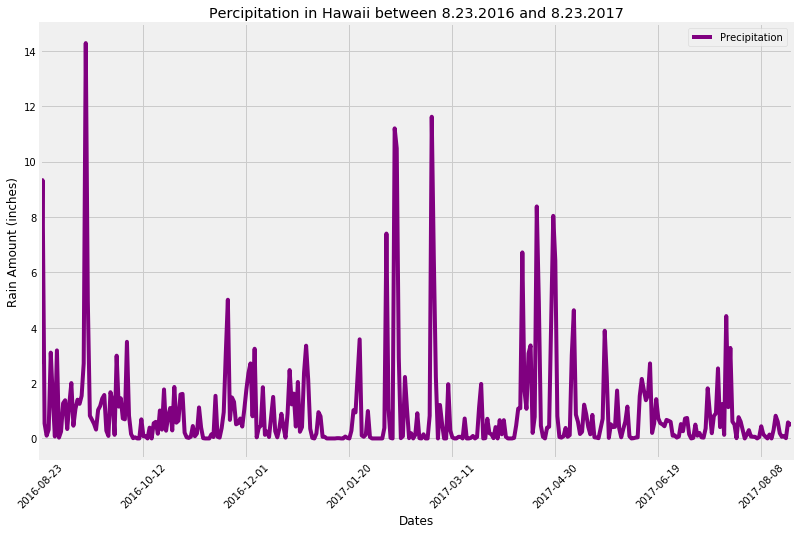

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

precp_df.plot.line(figsize=(12,8), rot=45, color='purple')
plt.grid(True)
plt.title('Percipitation in Hawaii between 8.23.2016 and 8.23.2017')
plt.xlabel('Dates')
plt.ylabel('Rain Amount (inches)')
plt.legend=True

plt.savefig("HawaiiPercip.png")
plt.show()

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
precp_df.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?

station_count=session.query(Station.id).count()
station_count
print(f"There are a total of {station_count} weather stations in Hawaii.")

There are a total of 9 weather stations in Hawaii.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?

station_activity = session.query(Measurement.station, func.count(Measurement.id)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count((Measurement.id)).\
desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

temp_stats=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

print(f"The min/max/avg temps for the most active weather station in Hawaii are {temp_stats}.")

The min/max/avg temps for the most active weather station in Hawaii are [(54.0, 85.0, 71.66378066378067)].


In [21]:
station_temps=session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= prev_year).all()
#station_temps

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperatures = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()

<Figure size 864x576 with 0 Axes>

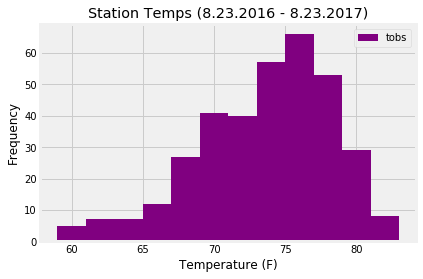

In [23]:
df = pd.DataFrame(temperatures, columns=['tobs'])
plt.figure(figsize=(12,8))
df.plot.hist(bins=12, color='purple')
#plt.tight_layout()

plt.title('Station Temps (8.23.2016 - 8.23.2017)')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.grid(True)

plt.savefig("StationTemps.png")
plt.show()


![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start=prev_year + dt.timedelta(days=90)
end=start + dt.timedelta(days=15)

temps=(calc_temps(start, end))

trip_temps= list(np.ravel(temps))
trip_temps

[67.0, 73.15686274509804, 78.0]

<function matplotlib.pyplot.show(*args, **kw)>

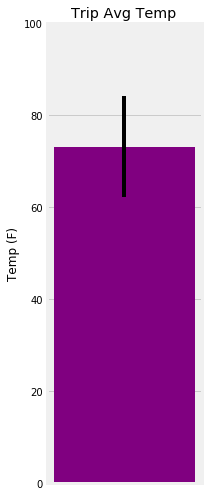

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin=trip_temps[0]
tmax=trip_temps[2]
tavg=trip_temps[1]
yerr=(tmax-tmin)
yerr

plt.figure(figsize=(3,7)) 
plt.bar(1,tavg, color='purple')
plt.errorbar(1,tavg, yerr, color='k')
plt.ylim(0,100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()

plt.savefig("TripAvgTemp.png")

plt.show

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_precp = session.query(Measurement.station, Station.name, Station.elevation, Station.latitude, \
                Station.longitude,func.count(Measurement.id)).filter(Measurement.date >= start, Measurement.date <= end).\
                filter(Measurement.prcp != None).filter(Measurement.station == Station.station).group_by(Measurement.station).\
                order_by(func.count((Measurement.id)).desc()).all()

In [28]:
station_precp_df=pd.DataFrame(station_precp,columns=['Station','Station Name', 'Elev', 'Lat','Lon', 'Precp'])
station_precp_df=station_precp_df.set_index('Station')

station_precp_df.head(20)

,Station Name,Elev,Lat,Lon,Precp
Station,,,,,
USC00513117,"KANEOHE 838.1, HI US",14.6,21.42340,-157.80150,16
USC00516128,"MANOA LYON ARBO 785.2, HI US",152.4,21.33310,-157.80250,16
USC00519281,"WAIHEE 837.5, HI US",32.9,21.45167,-157.84889,16
USC00519397,"WAIKIKI 717.2, HI US",3.0,21.27160,-157.81680,16
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",19.5,21.33556,-157.71139,16
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",7.0,21.52130,-157.83740,10


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [32]:
# Plot the daily normals as an area plot with `stacked=False`
